In [1]:
using CSV
using DataFrames
using DelimitedFiles
using CairoMakie
using FLoops
using JLD
using LaTeXStrings
using LsqFit
using Printf
using Revise
using Statistics
# CairoMakie.activate!(type = "svg")

In [2]:
dir = "Sample1_2022-09-01_142621";

15245.59184213528
0.0


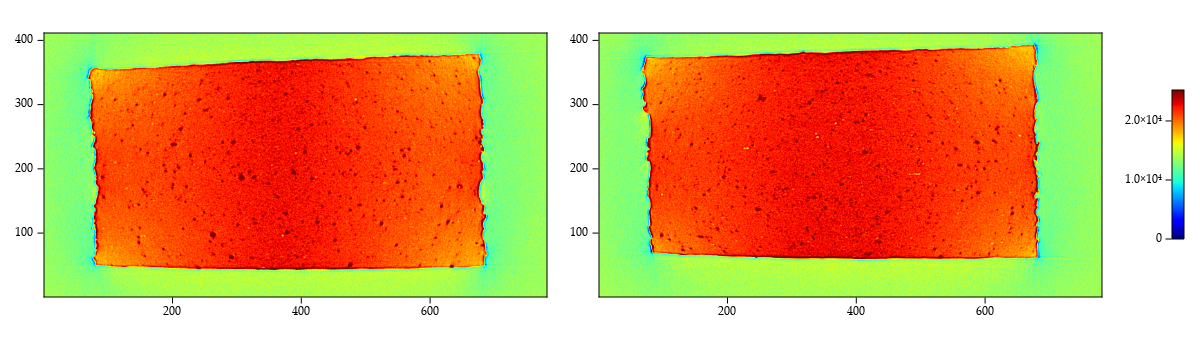

In [6]:
let
    B, B1 = readdlm(dir*"/tif/1.txt", Int32), readdlm(dir*"/tif/1005.txt", Int32)
    B_ave_inter = mean(B[100:end-100, 100:end-100])
    B_ave_outer = mean(B[1:end, 1])
    println(B_ave_inter)
    println(B_ave_outer)

    # px, py = 1:size(B,1), 1:size(B,2)
    px, py = 321:730, 121:900

    update_theme!(font = "Palatino Linotype", fontsize = 12)
    fig = Figure(resolution = (1200, 350))

    ax = Axis(fig[1, 1], aspect = DataAspect())
    hm = heatmap!(B[px,py]', colormap = :jet1, colorrange = (0, B_ave_inter+10000))
    #

    ax = Axis(fig[1, 2], aspect = DataAspect())
    hm = heatmap!(B1[px,py]', colormap = :jet1, colorrange = (0, B_ave_inter+10000))
    Colorbar(fig[1, 3], hm, height = Relative(0.5), flipaxis = false, width = 12)
    #
    display(fig)
end

In [3]:
# save act
if isfile(dir*"/act.jld")
    act_1 = load(dir*"/act.jld")["act"]
else
    data = zeros(Int32, 1024, 996, 1005)
    for i in 1:1005
        print(i, " ")
        data[:,:,i] = readdlm(dir*"/tif/"*string(i)*".txt", Int32)
    end
    save(dir*"/act.jld", "act", data[321:730, 121:900, :])
    act_1 = load(dir*"/act.jld")["act"]
end;

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [9]:
# volume test
A = act_1
lx, ly, lz = size(A)[1], size(A)[2], size(A)[3]
A1 = copy(A)
for k in 1:lz
    mod(k,50)>0 || print(k, " ")
    for i in 1:lx
        tem = A[i,:,k][:]
        iselect = tem.>22000
        if sum(iselect)==0
            A1[i,:,k].=0
        else
            A1[i, 1:collect(1:ly)[iselect][1]+5, k].=0 
            A1[i, collect(1:ly)[iselect][end]-5:ly, k].=0
        end
    end
    for j in 1:ly
        iselect = A[:,j,k][:].>22000
        if sum(iselect)==0
            A1[:,j,k].=0
        else
            A1[1:collect(1:lx)[iselect][1]+5, j, k].=0 
            A1[collect(1:lx)[iselect][end]-5:lx, j, k].=0
        end
    end
end

50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 

22933.787749508527


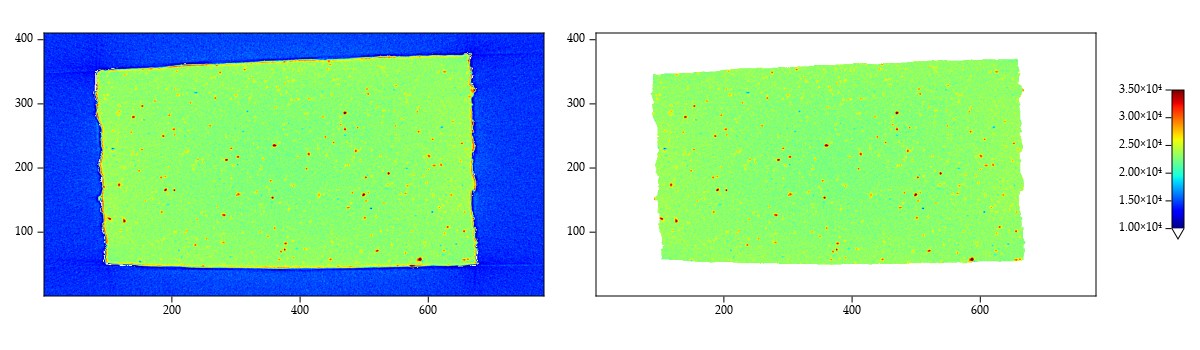

In [17]:
z = 39
B, B1 = A[:,:,z], A1[:,:,z]
B_ave_inter = mean(B[100:end-100, 100:end-100])
println(B_ave_inter)

px, py = 1:size(B,1), 1:size(B,2)
# px, py = 51:150, 51:250

update_theme!(font = "Palatino Linotype", fontsize = 12)
fig = Figure(resolution = (1200, 350))

ax = Axis(fig[1, 1], aspect = DataAspect())
hm = heatmap!(B[px,py]', colormap = :jet1, lowclip = :white, colorrange = (10000, 35000))
#

ax = Axis(fig[1, 2], aspect = DataAspect())
hm = heatmap!(B1[px,py]', colormap = :jet1, lowclip = :white, colorrange = (10000, 35000))
Colorbar(fig[1, 3], hm, height = Relative(0.5), flipaxis = false, width = 12)
#
display(fig)

In [21]:
A2 = copy(A1)
d, d1 = 5, 5
for k in 1+d:d1:lz-d
    print(k, " ")
    @floop for i in 1+d:d1:lx-d, j in 1+d:d1:ly-d
        tem = A1[i-d:i+d, j-d:j+d, k-d:k+d][:]
        if sum(tem.==0)>0
            A2[i-d:i+d, j-d:j+d, k-d:k+d] .= 0
        else
            tem = tem[tem.<median(tem)]
            bg = round(Int32, 1.2mean(tem[tem.<median(tem)]))
            for ii in i-d:i+d, jj in j-d:j+d, kk in k-d:k+d
                if A1[ii, jj, kk] < bg
                    A2[ii, jj, kk] = 0
                else
                    A2[ii, jj, kk] = A1[ii, jj, kk] - bg
                end
            end
        end
    end
end
save(dir*"/act_polish.jld", "act", A2);

6 11 16 21 26 31 36 41 46 51 56 61 66 71 76 81 86 91 96 101 106 111 116 121 126 131 136 141 146 151 156 161 166 171 176 181 186 191 196 201 206 211 216 221 226 231 236 241 246 251 256 261 266 271 276 281 286 291 296 301 306 311 316 321 326 331 336 341 346 351 356 361 366 371 376 381 386 391 396 401 406 411 416 421 426 431 436 441 446 451 456 461 466 471 476 481 486 491 496 501 506 511 516 521 526 531 536 541 546 551 556 561 566 571 576 581 586 591 596 601 606 611 616 621 626 631 636 641 646 651 656 661 666 671 676 681 686 691 696 701 706 711 716 721 726 731 736 741 746 751 756 761 766 771 776 781 786 791 796 801 806 811 816 821 826 831 836 841 846 851 856 861 866 871 876 881 886 891 896 901 906 911 916 921 926 931 936 941 946 951 956 961 966 971 976 981 986 991 996 

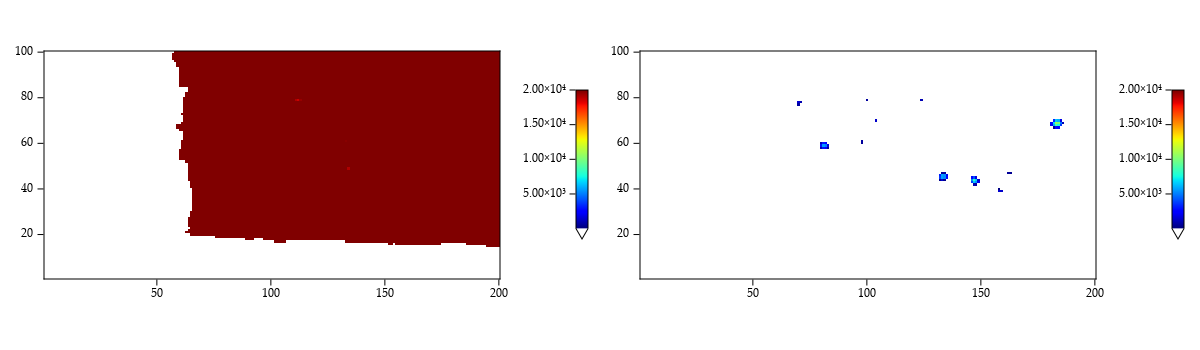

In [22]:
z = 700
B, B1 = A1[:,:,z], A2[:,:,z]

# px, py = 1:length(B[:,1]), 1:length(B[1,:])
px, py = 51:150, 51:250

update_theme!(font = "Palatino Linotype", fontsize = 12)
fig = Figure(resolution = (1200, 350))

ax = Axis(fig[1, 1], aspect = DataAspect())
hm = heatmap!(B[px,py]', colormap = :jet1, lowclip = :white, colorrange = (1, 20000))
Colorbar(fig[1, 2], hm, height = Relative(0.5), flipaxis = false, width = 12)
#

ax = Axis(fig[1, 3], aspect = DataAspect())
hm = heatmap!(B1[px,py]', colormap = :jet1, lowclip = :white, colorrange = (1, 20000))
Colorbar(fig[1, 4], hm, height = Relative(0.5), flipaxis = false, width = 12)
#
display(fig)